In [1]:
import tensorflow as tf
base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

2022-05-22 14:17:14.506923: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-22 14:17:14.506940: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-22 14:17:15.518978: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-22 14:17:15.518995: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-22 14:17:15.519006: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (smc): /proc/driver/nvidia/version does not exist
2022-05-22 14:17:15.519111: I tensorflow/core/platform/cpu_feature_guard.

In [2]:
def maximize_activation(starting_img,\
                        target_layer="mixed0", target_index=0,\
                        steps=10, step_size=0.1):

    # Take the network and cut it off at the layer we want to analyze,
    # i.e. we only need the part from the input to the target_layer.
    target = [base_model.get_layer(target_layer).output]
    part_model = tf.keras.Model(inputs=base_model.input, outputs=target)

    # The next part is the function to maximize the target layer/node by
    # adjusting the input, equivalent to the usual gradient descent but
    # gradient ascent. Run an optimization loop:
    def gradient_ascent(img, steps, step_size):
        loss = tf.constant(0.0)
        for n in tf.range(steps):
        # As in normal NN training, you want to record the computation
        # of the forward-pass (the part_model call below) to compute the
        # gradient afterwards. This is what tf.GradientTape does.
            with tf.GradientTape() as tape:
                tape.watch(img)
              # Forward-pass (compute the activation given our image)
                activation = part_model(tf.expand_dims(img, axis=0))
              # The activation will be of shape (1,N,N,L) where N is related to
              # the resolution of the input image (assuming our target layer is
              # a convolutional filter), and L is the size of the layer. E.g. for a
              # 256x256 image in "block4_conv1" of VGG19, this will be
              # (1,32,32,512) -- we select one of the 512 nodes (index) and
              # average over the rest (you can average selectively to affect
              # only part of the image but there's not really a point):
                loss = tf.math.reduce_mean(activation[:,:,:,target_index])

            # Get the gradient, i.e. derivative of "loss" with respect to input
            # and normalize.
            gradients = tape.gradient(loss, img)
            gradients /= tf.math.reduce_std(gradients)
        
    # In the final step move the image in the direction of the gradient to
    # increate the "loss" (our targeted activation). Note that the sign here
    # is opposite to the typical gradient descent (our "loss" is the target 
    # activation which we maximize, not something we minimize).
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)
        return loss, img

    # Preprocessing of the image (converts from [0..255] to [-1..1]
    img = tf.keras.applications.inception_v3.preprocess_input(starting_img)
    img = tf.convert_to_tensor(img)
    # Run the gradient ascent loop
    loss, img = gradient_ascent(img, tf.constant(steps), tf.constant(step_size))
    # Convert back to [0..255] and return the new image
    img = tf.cast(255*(img + 1.0)/2.0, tf.uint8)
    return img


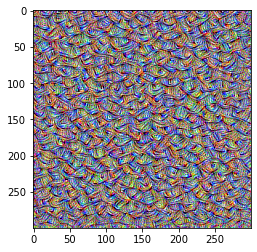

In [3]:
import numpy as np
import matplotlib.pyplot as plt

starting_img = np.random.randint(low=0,high=255,size=(300,300,3), dtype=np.uint8)
optimized_img = maximize_activation(starting_img, target_layer="block4_conv1", target_index=47, steps=10, step_size=0.1)
plt.imshow(np.array(optimized_img))
plt.savefig("images/img01.png")

From OpenAI Microscope: ![conv4_1](https://oaiggoh.blob.core.windows.net/microscopeprod/2020-07-25/2020-07-25/vgg19_caffe/lucid.feature_vis/_feature_vis/alpha%3DFalse%26negative%3DFalse%26objective%3Dchannel%26op%3Dconv4_1%252Fconv4_1%253A0%26repeat%3D0%26start%3D0%26steps%3D4096%26stop%3D32/channel-4.png)

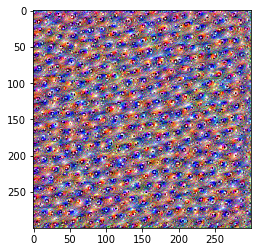

In [4]:
starting_img = np.random.randint(low=0,high=255,size=(300,300,3), dtype=np.uint8)
optimized_img = maximize_activation(starting_img,
                                    target_layer="block4_conv1", target_index=4,
                                    steps=20, step_size=0.1)
plt.imshow(np.array(optimized_img))
plt.savefig("images/img02.png")

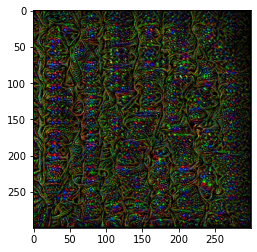

In [5]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
input_img = np.zeros((300,300,3), dtype=np.uint8)
optimized_img = maximize_activation(input_img,
                    target_layer="mixed3", target_index=1,
                    steps=20, step_size=0.1)
plt.imshow(np.array(optimized_img))
